# Tutorial: Recurrence Networks

This tutorial aims to introduce the analysis of non-linear timeseries with a complex network approach. Its application in the __pyunicorn__ package is illustrated in two examples to help understand the basic use of the `pyunicorn.timeseries.RecurrencePlot` as well as `pyunicorn.timeseries.RecurrenceNetwork` classes.

## 1. Introduction

### 1.1 Recurrence plots as an approach to analyze complex systems

So far, analysis of complex networks in different scientific fields, has been performed by the study of the adjacency matrix $A_{i,j}$. Recent work has been focussing on studying time series using a similar approach by tranforming the time series in a complex network and analyze the phase space and corresponding properties from the **Recurrence plot (RP)**. 

The recurrence matrix can be considered as the adjacency matrix of an undirected, unweighted network. With this approach it is possible to characterise the local and global properties of a network. 
In particular, this approach can be applied (i) to both univariate and multivariate time series (phase space trajectories), (ii) with and without pronounced oscillatory components and (iii) with as well as without embedding. Moreover, similar to traditional Recurrence Quantitative Analysis (RQA), studying network properties for sliding windows in time also allows for coping with non-stationary time series. Consequently, unlike for most of the existing techniques, there are no fundamental restrictions with respect to its practical applicability to arbitrary time series.

For more detailed background information consult [Marwan et al. (2009)](https://arxiv.org/abs/0907.3368).
 

### 1.2 Visualization of a timeseries and its recurrence network

Before we get started, we shall visualize a timeseries based on a three dimensional chaotic oscillator example described by the Lorenz system defined by:

$$\frac{d}{dt}(x,y,z)=(10(y-x),x(28-z)-y,xy-\frac{8}{3}z)$$

The following figures graphically represents the timeseries in phase space and what its respective recurrent plot looks like. 

![Recurrence Plot](images/REcurrencePlot_v2.png)

__(A)__ A state at time *i* (red dot) is recurrent at another time *j* (black dot) when the phase space trajectory visits its close neighborhood (gray circle). This is marked by value 1 in the recurrence matrix at *(i, j)*. States outside of this neighborhood (small red circle) are marked with 0 in the recurrence matrix. __(B)__ Graphical representation of the corresponding recurrence matrix (recurrence plot) and adjacency matrix (modulo main diagonal).

For literature review and background information see [Donner et al. (2010b)](https://www.researchgate.net/publication/47557940_Recurrence-based_time_series_analysis_by_means_of_complex_networkmethods) .


### 1.3 Correspondence between recurrence network and phase space measurements

The following table shows how some of the correponding characteristics measured from a recurrence network translate into phase space features of the time series.

For more background information consult [Donges et al. (2012)](https://www.researchgate.net/publication/225288426_Analytical_framework_for_recurrence_network_analysis_of_time_series)


| Scale | Recurrence Network | Phase space interpretation |
| :--- | :--- | :--- |
| Local | Continuous local $\epsilon$-clustering coefficient *C* <br/>  Continuous $\epsilon$-matching index | Local dimension <br/> Local density gradient | 
| Global | Continuous $\epsilon$-transitivity <br/>  Continuous global $\epsilon$-clustering <br/> | Global dimension <br/> Average local dimension | 


## 2. Example: Logistic Map

_Calculating properties of a time series through recurrence network analysis using a toy example._

First we import the necessary packages:

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from pyunicorn.timeseries import RecurrenceNetwork
from pyunicorn.timeseries import RecurrencePlot

We create a function to calculate a logistic map timeseries:

In [2]:
def logistic_map(x0, r, T, spinup=100):
    """
    Returns a time series of length T using the logistic map
    x_(n+1) = r*x_n(1-x_n) at parameter r and using the initial condition x0.

    INPUT: x0 - Initial condition, 0 <= x0 <= 1
            r - Bifurcation parameter, 0 <= r <= 4
            T - length of the desired time series
            spinup - number of spinup-timesteps before storing results to output
    OUTPUT: numpy array of timeseries under given parameters
    """
    # spinup
    for n in range(spinup):
        x0 = r * x0 * (1 - x0)

    #  Initialize timeSeries as python list with initial condition as first entry
    timeseries = [x0]

    for n in range(T):
        # get current timestep value
        xn = timeseries[n]
        # calculate next timestep value
        xstep = r * xn * (1 - xn)
        # append new timestep value to timeSeries
        timeseries.append(xstep)

    return np.array(timeseries)

After choosing the bifurcation parameter $r$, the initial value $x_0$ and the length of the timeseries $T$, we can now generate a timeseries. Play around with the parameters if you like! For an interesting regime, we should stick with $r >3.6$. 

(Note: Our logistic_map function includes a spinup of 100 timesteps by default, so the resulting timeseries will not start at $x_0$.)

Text(0, 0.5, '$x_n$')

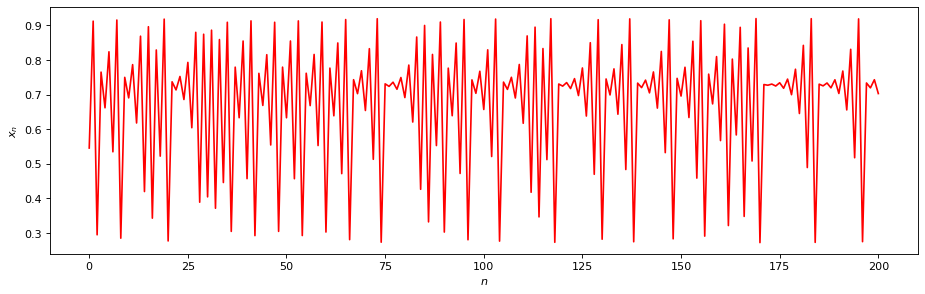

In [3]:
#  Parameters of logistic map
r = 3.679  # Bifurcation parameter
x0 = 0.7   # Initial value

#  Length of the time series
T = 200

#Generate the timeseries
time_series = logistic_map(x0, r, T)

#  Plot the time series
plt.figure(figsize=(14, 4), dpi=80)
plt.plot(time_series, "r")
plt.xlabel("$n$")
plt.ylabel("$x_n$")

### 2.1 Recurrence properties under fixed recurrence threshold $\epsilon$

Now we can create a recurrence plot from the created time series using the RecurrenePlot Class from pyunicorn. Following [Marwan et al,. 2009](https://arxiv.org/abs/0907.3368), we choose a fixed recurrence threshold $\epsilon$ that is 5% of the time series' standard deviation. For that purpose we set the parameter 'threshold_std'. (Note: For a one-dimensional timeseries we do not use embedding.)

Calculating recurrence plot at fixed threshold in units of time series STD...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


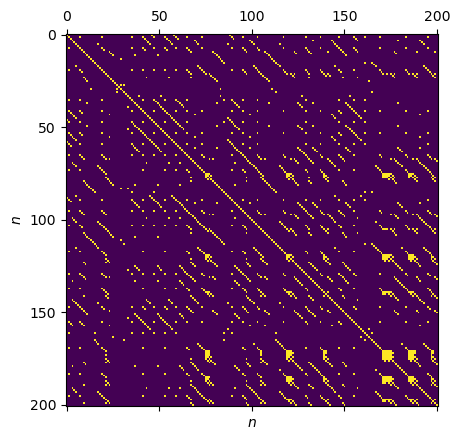

In [4]:
EPS_std = 0.05  # Fixed recurrence threshold in units of the time series' standard deviation

# Default distance metric in phase space: "supremum"
# Can also be set to "euclidean" or "manhattan".
METRIC = "supremum"

rp = RecurrencePlot(time_series, metric=METRIC,
                    normalize=False, threshold_std=EPS_std)

plt.matshow(rp.recurrence_matrix())
plt.xlabel("$n$")
plt.ylabel("$n$")
plt.show()

Some of the main properties of a recurrence plot can be easily extracted by applying the `rqa_summary()` method:

In [5]:
print(rp.rqa_summary())

{'RR': 0.05061755897131259, 'DET': 0.7494577006466949, 'L': 3.971264367701975, 'LAM': 0.10958904109535426}


#### Network calculation and properties

Now we can use the recurrence properties, which mimic the phase space properties of the time series to calculate quantitative characteristics of the time series implicitly. We shall distinghuish here between local, intermediate and global properties. To construct the complex network we use the RecurrenceNetwork Class combining the RecurrencePlot and Network (see Class Network from pyunicorn/core) charactistics. For more information on the individual properties see [Donner et al. (2010a)](https://iopscience.iop.org/article/10.1088/1367-2630/12/3/033025/meta). 

The main focus will lie on determining the local and global clustering coefficient as well as the network transitivity. 

In [6]:
rn = RecurrenceNetwork(time_series, metric=METRIC,
                       normalize=False, threshold_std=EPS_std)

Calculating recurrence plot at fixed threshold in units of time series STD...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


##### Local scale network properties: Local Clustering Coefficient

The local scale network properties consider only the direct neighbourhood within a defined $\epsilon$-ball of a vertex *v*.

The __local clustering coefficient__ of a vertex $v$, $C_v$, characterizes the density of connections in the direct neighbourhood of this vertex in terms of the density of connections between all vertices that are incident with $v$.

We consider the clustering coefficient by Watts and Strogatz:

$$C_v=\frac{2}{k_v(k_v-1)}N^\Delta_v$$

whereby $N^\Delta_v$ represents the number of closed triangles including vertex $v$ and $k_v$ stands for the local recurrence rate around a vertex $v$.

Calculating local clustering coefficients...


Text(0, 0.5, '$C_v$')

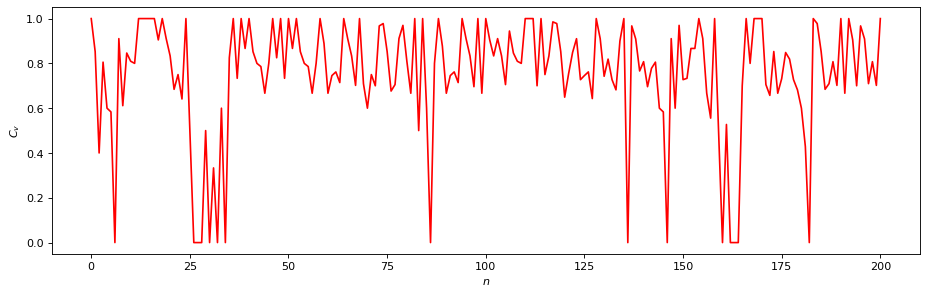

In [7]:
C_v = rn.local_clustering()  #rn being the recurrence network

plt.figure(figsize=(14, 4), dpi=80)
plt.plot(C_v, "r")
plt.xlabel("$n$")
plt.ylabel("$C_v$")

##### Global scale network properties: Global clustering coefficient and network transitivity

Global scale network properties take all vertices into account.

The __global clustering coefficient__ is considered as the average value of the clustering coefficient taken over all vertices of a network. It is calculated as

$$C=\frac{1}{N}\sum_{v=1}^{N}C_v$$

In [8]:
C = rn.global_clustering()
print(f"C = {C}")

Calculating global clustering coefficient (C_2)...
C = 0.7532331807249787


The __transitivity__  $T$ of a network measures the probability that two neighbors (i.e. recurrences) of any state are also neighbors. It can be calculated from the link matrix $A_{i,j}$ of the network as

$$T = \frac{\sum_{i,j,k=1}^N A_{i,j}A_{j,k}A_{k,i}}{\sum_{i,j,k=1}^N A_{i,j}A_{k,i}}$$

where $A_{i,j} = R_{i,j} - \delta_{i,j}$, with the recurrence matrix $R_{i,j}$ and the Kronecker-delta $\delta_{i,j}$.

In [9]:
T = rn.transitivity()
print(f"T = {T}")

Calculating transitivity coefficient (C_1)...
T = 0.8021460350693536


### 2.2 Recurrence properties under fixed recurrence rate $RR$

For comparison, we now calculate the same recurrence properties using a fixed recurrence rate.

Calculating recurrence plot at fixed recurrence rate...
Calculating the supremum distance matrix...


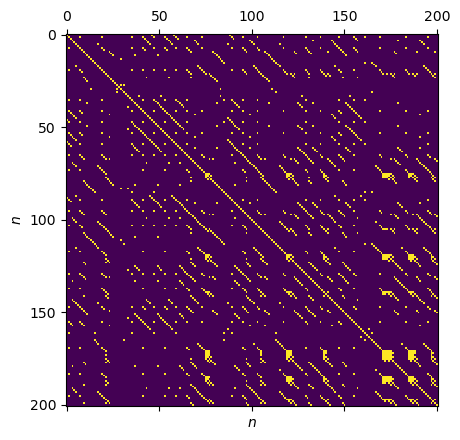

Calculating recurrence plot at fixed recurrence rate...
Calculating the supremum distance matrix...
Calculating local clustering coefficients...


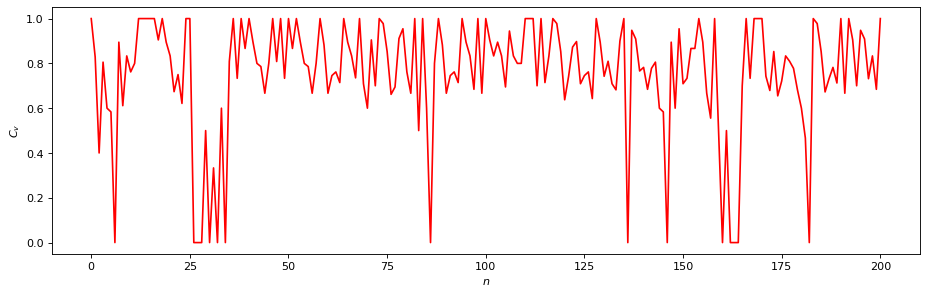

Calculating global clustering coefficient (C_2)...
C = 0.7544336150477271

Calculating transitivity coefficient (C_1)...
T = 0.8005944339367739


In [10]:
RR = 0.05  # choose fixed recurrence rate

# Default distance metric in phase space: "supremum"
# Can also be set to "euclidean" or "manhattan".
METRIC = "supremum"

rp = RecurrencePlot(time_series, metric=METRIC,
                    normalize=False, recurrence_rate=RR)

plt.matshow(rp.recurrence_matrix())
plt.xlabel("$n$")
plt.ylabel("$n$")
plt.show()

# calculate recurrence network
rn = RecurrenceNetwork(time_series, metric=METRIC,
                       normalize=False, recurrence_rate=RR)

## Local measures: 
# Local Clustering Coefficients
C_v = rn.local_clustering()

# plot
plt.figure(figsize=(14, 4), dpi=80)
plt.plot(C_v, "r")
plt.xlabel("$n$")
plt.ylabel("$C_v$")
plt.show()

## Global measures: 
# Global Clustering Coefficient
C = rn.global_clustering()
print(f"C = {C}")
print()

# Transitivity
T = rn.transitivity()
print(f"T = {T}")

## 3. Example: Lorenz Attractor 

_Calculating properties of a time series by recurrence network analysis using Lorenz attractor example._

In this example we will be using a complex chaotic system to calculate recurrence network properties from it: The Lorenz attractor. It is defined by
$$\frac{d}{dt}(x,y,z)=\left(10(y-x)\right(28-z),xy-\frac{8}{3}z)$$

In [2]:
def Lorenz_timeseries(dt=0.01, num_steps=10000, x0=0., y0=1., z0=1.05, s=10., r=28., b=2.667, spinup=100):
   """
   Given:
      dt: length of timestep
      num_steps: number of timesteps
      x0, y0, z0: initial values for timeseries
      s, r, b: parameters defining the lorenz attractor
      spinup: number of spinup-timesteps before storing results to output
   Returns:
      timeseries: numpy array of three dimensional timeseries on Lorenz attractor with length num_steps
   """
   
   # spinup
   for n in range(spinup):
      x0 += (s*(y0 - x0)) * dt
      y0 += (r*x0 - y0 - x0*z0) * dt
      z0 += (x0*y0 - b*z0) * dt

   # initialize timeseries with spun-up initial values
   x = [x0]
   y = [y0]
   z = [z0]

   # calculate timeseries
   for n in range(num_steps-1):
      # get current values
      xn = x[n]
      yn = y[n]
      zn = z[n]
      # calculate next timestep values
      xstep = xn + (s*(yn - xn)) * dt
      ystep = yn + (r*xn - yn - xn*zn) * dt
      zstep = zn + (xn*yn - b*zn) * dt
      # append to timeseries
      x.append(xstep)
      y.append(ystep)
      z.append(zstep)

   timeseries = np.transpose([x,y,z])
   
   return timeseries

Now calculate a timeseries on the Lorenz attractor with the defined function. Try different timesteps, initial values and Lorenz parameters, or just use the default ones defined above.

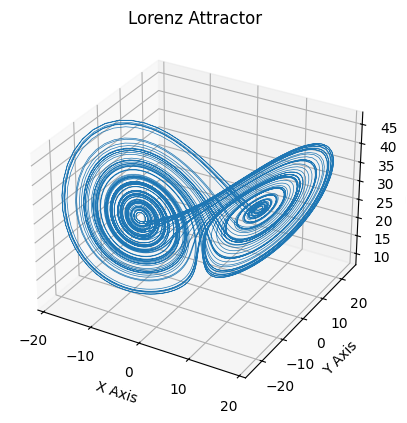

In [3]:
# calculate timeseries on Lorenz attractor 
Lorenz = Lorenz_timeseries(spinup=100)

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(Lorenz[:,0], Lorenz[:,1], Lorenz[:,2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

Calculate the recurrence plot for this three dimensional timeseries while using a fixed recurrence rate.

Calculating recurrence plot at fixed recurrence rate...
Calculating the supremum distance matrix...


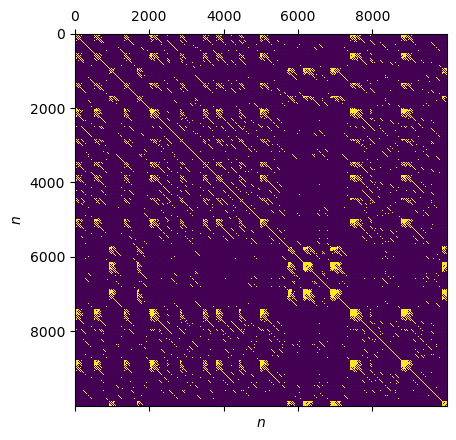

In [13]:
# choose fixed recurrence rate
RR = 0.05

#For the obtained timeseries, calculate recurrence plot for a fixed global recurrence rate
Lorenz_rp = RecurrencePlot(Lorenz, recurrence_rate=RR) #supremum metric is used by default

#Show plot
plt.matshow(Lorenz_rp.recurrence_matrix())
plt.xlabel("$n$")
plt.ylabel("$n$")
plt.show()

#### Local clustering coefficient

Calculate local clustering coefficient and dimension of generated Lorenz timeseries and visualize result on plot.

In [14]:
# Calculate RecurrenceNetwork of generated Lorenz-timeseries
Lorenz_rn = RecurrenceNetwork(Lorenz,  metric = "supremum", recurrence_rate=0.05)

# From obtained RecurrenceNetwork calculate local clustering coefficients
Lorenz_C_v = Lorenz_rn.local_clustering() 

print(f"C_v = {Lorenz_C_v}")

Calculating recurrence plot at fixed recurrence rate...
Calculating the supremum distance matrix...
Calculating local clustering coefficients...
C_v = [0.65332227 0.65165906 0.64570268 ... 0.65980106 0.65624366 0.6570686 ]


From the local clustering coefficient we can calculate the local clustering dimension $CD_v$ by taking the log of the local clustering coefficient $C_v$ and dividing it by $log(3/4)$:

$$CD_v=\frac{log(C_v)}{log(\frac{3}{4})}$$


In [15]:
# Calculate CD_v
CD_v = np.log(Lorenz_C_v)/np.log(3/4)

print(f"CD_v = {CD_v}")

CD_v = [1.47970552 1.48856605 1.52048446 ... 1.44540435 1.46419666 1.45982974]


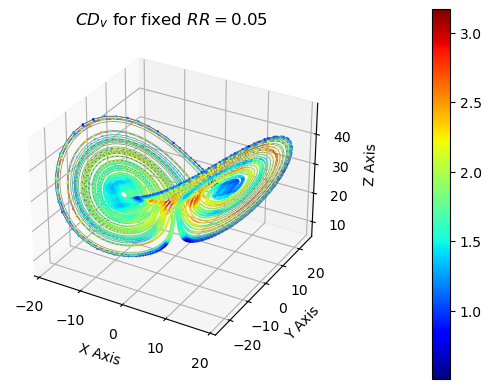

In [16]:
# Plot local clustering dimension on Lorenz attractor
# get colormap
cm = plt.cm.get_cmap('jet')
ax = plt.figure().add_subplot(projection='3d')

# plot underlying trajectory
ax.plot(Lorenz[:, 0], Lorenz[:, 1], Lorenz[:, 2], lw=0.5, color="grey")
# plot LCD 
scat_plot = ax.scatter(Lorenz[:, 0], Lorenz[:, 1], Lorenz[:, 2], lw=0.5, c=CD_v, s=1, cmap=cm)
cb = plt.colorbar(scat_plot, pad=0.2)

ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")

ax.set_title("$CD_v$ for fixed $RR = 0.05$")
plt.show()

#### Global clustering coefficient

Here, we can calculate the global clustering coefficient and dimension of the generated Lorenz timeseries and visualize the results on plot

In [17]:
# Apply global_clustering method to get global clustering coefficient (C)
C = Lorenz_rn.global_clustering()

print(f"C = {C}")

Calculating global clustering coefficient (C_2)...
C = 0.6179359105713065


From the global clustering coefficient we can calculate the global clustering dimension (CD) by taking the log of the global clustering coefficient and dividing it by log (3/4)

$$CD=\frac{log(C)}{log(\frac{3}{4})}$$

In [18]:
CD = np.log10(C)/np.log10(3/4)
print(f"CD = {CD}")

CD = 1.67327260741976


#### Transitivity

Finally we will calculate the transitivity $T$ and its corresponding dimension $TD$ of the generated Lorenz timeseries and visualize the results on a plot.

In [19]:
# Calculate transitivity from RecurrenceNetwork of our timeseries
Lorenz_T = Lorenz_rn.transitivity() 
print(f"T = {Lorenz_T}")

Calculating transitivity coefficient (C_1)...
T = 0.6405742697542526


From the transitivity we can calculate the transitivity dimension $TD$ by taking the log of the transitivity value and dividing it by log (3/4)

$$TD=\frac{log(T)}{log(\frac{3}{4})}$$

In [20]:
TD = np.log(Lorenz_T)/np.log(3/4)
print(f"TD = {TD}")

TD = 1.5482028639163619


### 3.1 Bonus exercise: Transitivity dimension for sweeping recurrence rate

We can also calculate the transitivity dimension for an array of different recurrence rates. (Note: this will be somewhat computationally expensive and might take some time to finish). We first create an array of recurrence rates to calculate the transitivity dimensions for, and then loop over it:

In [10]:
# define array of epsilon to calculate transitivity dimensions for
rr = np.arange(0.02, .22, 0.04) # for quick test (~ 5 min)
#rr = np.arange(0.05, 1.05, 0.05) # for a more extensive calculation (~ 20 min)

# calculate transitivity for different recurrence rate values in a loop (with progressbar)
TD = []
for r in tqdm(rr):
    # calculate transitivity from RecurrenceNetwork
    T_r = RecurrenceNetwork(Lorenz, recurrence_rate=r, silence_level=2).transitivity() # ~30s runtime
    # calculate transitivity dimension
    TD_r = (np.log10(T_r))/np.log10(3/4)
    # append to list
    TD.append(TD_r)

  0%|          | 0/5 [00:00<?, ?it/s]

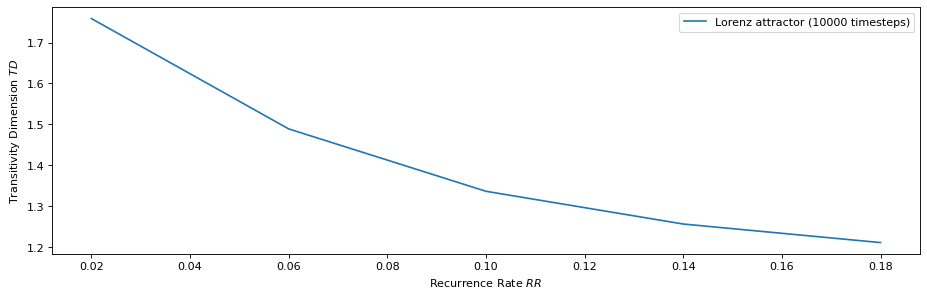

In [11]:
# Plot series
plt.figure(figsize=(14, 4), dpi=80)
plt.plot(rr, TD, label= "Lorenz attractor (10000 timesteps)") 
plt.xlabel('Recurrence Rate $RR$')
plt.ylabel('Transitivity Dimension $TD$')
plt.legend(loc = "upper right")
plt.show()